Setup

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy import stats
import statsmodels.stats.api as sms
import plotly.express as px
import warnings; warnings.filterwarnings("ignore")
np.random.seed(42)

Load data

In [2]:
# Robust loader for UCI Online Retail II (handles column name variants)
import pandas as pd

# 1) Path to your Excel
DATA_PATH = "/content/online_retail_II.xlsx"  # <-- update if needed

# 2) Read both sheets; coerce invoice fields to string so we can detect credit notes (start with 'C')
df1 = pd.read_excel(DATA_PATH, sheet_name="Year 2010-2011", dtype={"Invoice": str, "InvoiceNo": str})
df2 = pd.read_excel(DATA_PATH, sheet_name="Year 2009-2010", dtype={"Invoice": str, "InvoiceNo": str})
raw = pd.concat([df1, df2], ignore_index=True)

# 3) Normalize column names (lowercase, underscores)
raw.columns = (
    raw.columns
       .str.strip()
       .str.lower()
       .str.replace(r"[ /]", "_", regex=True)
)

# 4) Unify to a common schema
rename_map = {
    "invoice_date": "invoice_date",   # keep as is if already normalized
    "invoicedate": "invoice_date",

    "invoice": "invoice_no",
    "invoiceno": "invoice_no",

    "customer_id": "customer_id",
    "customerid": "customer_id",

    "stockcode": "stock_code",
    "description": "description",
    "country": "country",

    "quantity": "quantity",

    # price variants
    "unitprice": "unit_price",
    "price": "unit_price",   # some dumps use 'price'
}
raw = raw.rename(columns={c: rename_map.get(c, c) for c in raw.columns})

# 5) Validate required columns
required = ["invoice_date", "invoice_no", "customer_id", "quantity", "unit_price"]
missing = [c for c in required if c not in raw.columns]
if missing:
    raise ValueError(f"Missing columns after normalization: {missing}\nAvailable: {list(raw.columns)}")

# 6) Clean types and rows
raw["invoice_date"] = pd.to_datetime(raw["invoice_date"], errors="coerce")
raw = raw.dropna(subset=["invoice_date", "customer_id"]).copy()
raw["customer_id"] = raw["customer_id"].astype(str)

raw["quantity"]   = pd.to_numeric(raw["quantity"], errors="coerce")
raw["unit_price"] = pd.to_numeric(raw["unit_price"], errors="coerce")

# Remove credit notes (invoices starting with 'C') and invalid qty/price
mask_valid = (
    (~raw["invoice_no"].astype(str).str.startswith("C", na=False)) &
    (raw["quantity"] > 0) &
    (raw["unit_price"] > 0)
)
raw = raw.loc[mask_valid].copy()

# 7) Build the transaction table expected by the notebook
raw["amount"] = raw["quantity"] * raw["unit_price"]
tx = (
    raw.loc[:, ["customer_id", "invoice_date", "amount"]]
       .sort_values(["customer_id", "invoice_date"])
       .reset_index(drop=True)
)

print(tx.head(), tx.shape)

  customer_id        invoice_date  amount
0     12346.0 2009-12-14 08:34:00    45.0
1     12346.0 2009-12-14 11:00:00    22.5
2     12346.0 2009-12-14 11:02:00    22.5
3     12346.0 2009-12-18 10:47:00    22.5
4     12346.0 2009-12-18 10:55:00     1.0 (805549, 3)


Compute RFM features

In [3]:
snapshot_date = tx["invoice_date"].max() + pd.Timedelta(days=1)

rfm = (
    tx.groupby("customer_id")
      .agg(
          recency_days = ("invoice_date", lambda s: (snapshot_date - s.max()).days),
          frequency    = ("invoice_date", "count"),
          monetary     = ("amount", "sum")
      )
      .reset_index()
)

# optional: average order value
rfm["aov"] = rfm["monetary"] / rfm["frequency"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_days,5878.0,201.331916,209.338707,1.000000,26.000000,96.000000,380.000000,739.00
frequency,5878.0,137.044743,353.818629,1.000000,21.000000,53.000000,142.000000,12890.00
monetary,5878.0,3018.616737,14737.731040,2.950000,348.762500,898.915000,2307.090000,608821.65
aov,5878.0,48.299996,780.177864,2.042182,11.470705,17.354064,24.195021,56157.50


Scale & K-Means (choose K via elbow + silhouette)

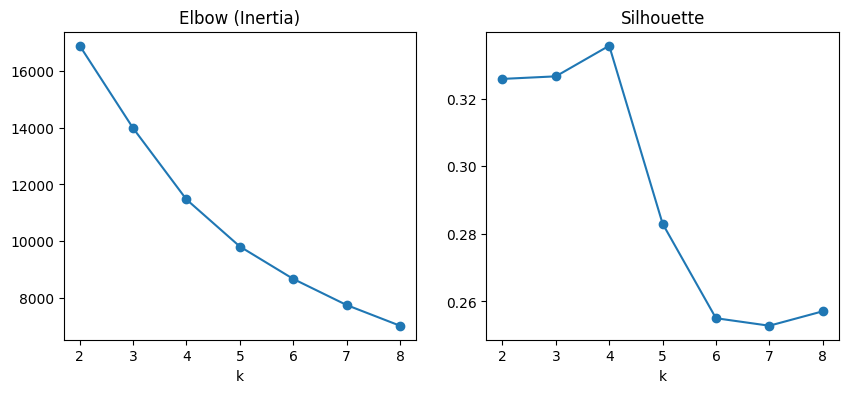

4

In [4]:
features = ["recency_days","frequency","monetary","aov"]
X = rfm[features].copy()
X["recency_days"] = np.log1p(X["recency_days"])     # mild skew correction
X["monetary"]     = np.log1p(X["monetary"])
X["aov"]          = np.log1p(X["aov"])

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

ks = range(2, 9)
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xs, labels))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(ks, inertias, "-o"); ax[0].set_title("Elbow (Inertia)"); ax[0].set_xlabel("k")
ax[1].plot(ks, sils, "-o"); ax[1].set_title("Silhouette"); ax[1].set_xlabel("k")
plt.show()

best_k = int(ks[np.argmax(sils)])  # or pick by elbow
best_k

In [5]:
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
rfm["kmeans_cluster"] = kmeans.fit_predict(Xs)
rfm.head()

,customer_id,recency_days,frequency,monetary,aov,kmeans_cluster
0,12346.0,326,34,77556.46,2281.072353,1
1,12347.0,2,253,5633.32,22.266087,3
2,12348.0,75,51,2019.40,39.596078,1
3,12349.0,19,175,4428.69,25.306800,3
4,12350.0,310,17,334.40,19.670588,0


Cluster profiling

In [6]:
profile = (
    rfm.groupby("kmeans_cluster")
       .agg(customers=("customer_id","count"),
            recency_days=("recency_days","median"),
            frequency=("frequency","median"),
            monetary=("monetary","median"),
            aov=("aov","median"))
       .sort_values("customers", ascending=False)
)
profile

,customers,recency_days,frequency,monetary,aov
kmeans_cluster,,,,,
0,3046,335.0,29.0,391.405,16.320399
3,2236,22.0,164.0,2399.120,17.182366
1,588,109.0,26.0,1995.670,80.156884
2,8,1.5,5838.5,93827.615,19.535143


In [7]:
def label_row(row, prof=profile):
    # heuristic: higher freq/monetary + lower recency => more valuable
    if   row["frequency"]>prof["frequency"].median() and row["monetary"]>prof["monetary"].median() and row["recency_days"]<prof["recency_days"].median():
        return "Champions"
    elif row["frequency"]>prof["frequency"].median() and row["recency_days"]<prof["recency_days"].median():
        return "Loyal"
    elif row["monetary"]>prof["monetary"].median():
        return "High-Value"
    elif row["recency_days"]>prof["recency_days"].median():
        return "At-Risk"
    else:
        return "Value"

rfm["segment"] = rfm.apply(label_row, axis=1)
rfm.segment.value_counts()

,count
segment,
At-Risk,2941
Value,1029
Champions,998
High-Value,531
Loyal,379


Visualize clusters in 2D PCA

In [8]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(Xs)
viz = pd.DataFrame(coords, columns=["pc1","pc2"])
viz["cluster"] = rfm["kmeans_cluster"]
fig = px.scatter(viz, x="pc1", y="pc2", color="cluster", title="K-Means clusters (PCA 2D)")
fig.show()

In [9]:
dbs = DBSCAN(eps=0.9, min_samples=25)
rfm["dbscan"] = dbs.fit_predict(Xs)
rfm["dbscan"].value_counts()

,count
dbscan,
0,5762
-1,116


Simulate campaign & run A/B test

In [10]:
base_conv = {"Champions":0.15, "Loyal":0.12, "High-Value":0.10, "Value":0.05, "At-Risk":0.02}
uplift    = {"Champions":0.02, "Loyal":0.02, "High-Value":0.03, "Value":0.02, "At-Risk":0.01}  # absolute

ab = rfm[["customer_id","segment","kmeans_cluster"]].copy()
ab["variant"] = np.where(np.random.rand(len(ab))<0.5, "A","B")
p = ab.apply(lambda r: base_conv.get(r["segment"],0.05) + (uplift.get(r["segment"],0.0) if r["variant"]=="B" else 0.0), axis=1)
ab["converted"] = (np.random.rand(len(ab)) < p).astype(int)

ab.head()

,customer_id,segment,kmeans_cluster,variant,converted
0,12346.0,High-Value,1,A,0
1,12347.0,Champions,3,B,0
2,12348.0,At-Risk,1,B,0
3,12349.0,Champions,3,B,0
4,12350.0,At-Risk,0,A,0


Overall A/B results (proportions z-test + CI)

In [11]:
def ab_summary(df):
    g = df.groupby("variant").agg(n=("customer_id","count"), conv=("converted","sum"))
    g["cr"] = g["conv"]/g["n"]
    A, B = g.loc["A"], g.loc["B"]
    # z-test for difference in proportions
    p_pool = (A.conv + B.conv) / (A.n + B.n)
    se = np.sqrt(p_pool*(1-p_pool)*(1/A.n + 1/B.n))
    z = (B.cr - A.cr)/se
    pval = 2*(1-stats.norm.cdf(abs(z)))
    # CI for lift (B-A)
    diff = B.cr - A.cr
    ci_low, ci_high = diff - 1.96*se, diff + 1.96*se
    return pd.DataFrame({
        "A_n":[A.n], "A_CR":[A.cr],
        "B_n":[B.n], "B_CR":[B.cr],
        "Lift (B-A)":[diff], "95% CI low":[ci_low], "95% CI high":[ci_high], "p_value":[pval]
    })

overall = ab_summary(ab)
overall

,A_n,A_CR,B_n,B_CR,Lift (B-A),95% CI low,95% CI high,p_value
0,2946.0,0.062118,2932.0,0.076398,0.01428,0.0013,0.02726,0.031057


Segment-level A/B (multiple testing aware)

In [12]:
seg_summaries = []
for seg, g in ab.groupby("segment"):
    row = ab_summary(g).assign(segment=seg)
    seg_summaries.append(row)
seg_tbl = pd.concat(seg_summaries, ignore_index=True)

# Benjamini–Hochberg FDR to control false discoveries across segments
seg_tbl = seg_tbl.sort_values("p_value")
m = len(seg_tbl)
seg_tbl["BH_crit"] = [((i+1)/m)*0.05 for i in range(m)]
seg_tbl["BH_significant"] = seg_tbl["p_value"] <= seg_tbl["BH_crit"]
seg_tbl

,A_n,A_CR,B_n,B_CR,Lift (B-A),95% CI low,95% CI high,p_value,segment,BH_crit,BH_significant
2,272.0,0.084559,259.0,0.123552,0.038993,-0.012858,0.090845,0.140491,High-Value,0.01,False
4,515.0,0.044660,514.0,0.064202,0.019542,-0.008179,0.047263,0.167063,Value,0.02,False
3,190.0,0.110526,189.0,0.148148,0.037622,-0.029937,0.105181,0.275066,Loyal,0.03,False
1,485.0,0.156701,513.0,0.175439,0.018738,-0.027487,0.064963,0.426906,Champions,0.04,False
0,1484.0,0.026954,1457.0,0.028140,0.001186,-0.010644,0.013016,0.844243,At-Risk,0.05,False


ROI model (overall + per segment)

In [13]:
CPI = 0.02          # $ spent per contacted user
PROFIT_PER_CONV = 20.0  # margin per conversion

def roi_block(df):
    g = df.groupby("variant").agg(n=("customer_id","count"), conv=("converted","sum"))
    g["cr"] = g["conv"]/g["n"]
    A, B = g.loc["A"], g.loc["B"]
    incr_conversions = (B.cr - A.cr) * min(A.n, B.n)  # conservative
    incr_profit = incr_conversions * PROFIT_PER_CONV
    incr_cost   = (B.n - A.n) * CPI  # if equal splits, ~0; adjust if not
    roi = (incr_profit - incr_cost) / max(incr_cost, 1e-9)
    return pd.Series({"incr_conversions":incr_conversions, "incr_profit":incr_profit, "incr_cost":incr_cost, "ROI":roi})

roi_overall = roi_block(ab)
roi_by_seg = ab.groupby("segment").apply(roi_block).reset_index()
roi_overall, roi_by_seg.head()

(incr_conversions    4.186965e+01
 incr_profit         8.373931e+02
 incr_cost          -2.800000e-01
 ROI                 8.376731e+11
 dtype: float64,
       segment  incr_conversions  incr_profit  incr_cost           ROI
 0     At-Risk          1.727763    34.555256      -0.54  3.509526e+10
 1   Champions          9.087719   181.754386       0.56  3.235614e+02
 2  High-Value         10.099265   201.985294      -0.26  2.022453e+11
 3       Loyal          7.110526   142.210526      -0.02  1.422305e+11
 4       Value         10.044660   200.893204      -0.02  2.009132e+11)

Power & sample size

In [14]:
#How many users do we need to detect a lift L with power 1–β at α=0.05?
baseline_cr = overall["A_CR"].iloc[0]
detectable_lift = 0.02  # absolute (e.g., +2pp)
effect = detectable_lift
power_analysis = sms.NormalIndPower()
required_n_per_arm = power_analysis.solve_power(
    effect_size = sms.proportion_effectsize(baseline_cr, baseline_cr + effect),
    power=0.8, alpha=0.05, ratio=1.0, alternative='two-sided'
)
required_n_per_arm

2614.0088271037393

Visuals & exports

In [15]:
# Plot segment conversion lift with CI
seg_plot = seg_tbl.copy()
seg_plot["Lift_mid"] = seg_plot["Lift (B-A)"]
fig = px.scatter(seg_plot, x="segment", y="Lift_mid", color="BH_significant",
                 error_y=seg_plot["95% CI high"]-seg_plot["Lift_mid"],
                 error_y_minus=seg_plot["Lift_mid"]-seg_plot["95% CI low"],
                 title="Segment uplift (B-A) with 95% CI")
fig.update_layout(xaxis_title="", yaxis_title="Lift")
fig.show()

# Export tables
overall.to_csv("ab_overall.csv", index=False)
seg_tbl.to_csv("ab_by_segment.csv", index=False)
roi_by_seg.to_csv("roi_by_segment.csv", index=False)

print("Saved: ab_overall.csv, ab_by_segment.csv, roi_by_segment.csv")

Saved: ab_overall.csv, ab_by_segment.csv, roi_by_segment.csv
